Weather EDA

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy import stats
from scipy.stats import pearsonr, spearmanr, ttest_ind, f_oneway

In [78]:
#plotting configuration
plt.style.use('default')
sns.set_palette("husl")

In [79]:
def load_dataset():
    print("Loading cleaned dataset...")
    
    df = pd.read_csv('cleaned_energy_data.csv')
    df['INTERVAL_DATE'] = pd.to_datetime(df['INTERVAL_DATE'])
    
    #time columns 
    time_cols = [col for col in df.columns if '.' in col and '-' in col]
    all_icps = df['ICP_IDENTIFIER'].unique()
    
    print(f"Date range: {df['INTERVAL_DATE'].min().date()} to {df['INTERVAL_DATE'].max().date()}")
    print(f"Number of ICPs: {len(all_icps)}")
 
    #temporal features
    df['Year'] = df['INTERVAL_DATE'].dt.year
    df['Month'] = df['INTERVAL_DATE'].dt.month
    df['DayOfWeek'] = df['INTERVAL_DATE'].dt.day_name()
    df['Season'] = df['Month'].map({12: 'Summer', 1: 'Summer', 2: 'Summer',
                                    3: 'Autumn', 4: 'Autumn', 5: 'Autumn',
                                    6: 'Winter', 7: 'Winter', 8: 'Winter',
                                    9: 'Spring', 10: 'Spring', 11: 'Spring'})
    

    #converting energy (kWh) to average power (kW) for 30-minute intervals
    print("Converting from kWh to kW for power demand analysis...")
    df[time_cols] = df[time_cols] * 2
    df['daily_power_total'] = df[time_cols].sum(axis=1)

    return df, time_cols

In [80]:
def load_weather_dataset():
    print("Loading weather dataset...")
    
    #energy data
    energy_df, time_cols = load_dataset()
    
    #weather data
    print("\nLoading weather dataset...")
    weather_df = pd.read_csv('weather_30min_aggregated.csv')
    
    #datetime columns
    weather_df['DATETIME'] = pd.to_datetime(weather_df['DATETIME'])
    weather_df['DATE'] = pd.to_datetime(weather_df['DATE'], format='%d/%m/%y').dt.date
    
    #adding temporal features to weather data
    weather_df['Year'] = weather_df['DATETIME'].dt.year
    weather_df['Month'] = weather_df['DATETIME'].dt.month
    weather_df['Hour'] = weather_df['DATETIME'].dt.hour
    weather_df['Season'] = weather_df['Month'].map({12: 'Summer', 1: 'Summer', 2: 'Summer',
                                                    3: 'Autumn', 4: 'Autumn', 5: 'Autumn',
                                                    6: 'Winter', 7: 'Winter', 8: 'Winter',
                                                    9: 'Spring', 10: 'Spring', 11: 'Spring'})
    
    print(f"Weather data date range: {weather_df['DATETIME'].min().date()} to {weather_df['DATETIME'].max().date()}")
    print(f"Energy data: {len(energy_df):,} records")
    print(f"Weather data: {len(weather_df):,} records")
    
    print(f"\nWeather data sample:")
    print(weather_df[['DATETIME', 'TEMP', 'RH', 'WINDSPD', 'RAIN', 'GLOBAL']].head())
    
    return energy_df, weather_df, time_cols

In [81]:
def circular_mean_degrees(angles):
    #for wind direction (degrees)
    #converting to radians
    angles_rad = np.radians(angles)
    #mean of unit vectors
    mean_x = np.mean(np.cos(angles_rad))
    mean_y = np.mean(np.sin(angles_rad))
    #converting back to degrees
    mean_angle_rad = np.arctan2(mean_y, mean_x)
    mean_angle_deg = np.degrees(mean_angle_rad)
    #positive angle (0-360)
    if mean_angle_deg < 0:
        mean_angle_deg += 360
    return mean_angle_deg

In [82]:
def analyze_weather_energy_correlation(energy_df, weather_df, time_cols):
    #Correlation matrix between weather variables and power demand
    print("1. WEATHER-POWER DEMAND CORRELATION ANALYSIS")
    
    energy_df['daily_total'] = energy_df['daily_power_total']  # Use pre-calculated

    daily_energy = energy_df.groupby(energy_df['INTERVAL_DATE'].dt.date).agg({
        **{col: 'mean' for col in time_cols},
        'daily_total': 'first' 
    }).reset_index()
    daily_energy.columns = ['DATE'] + list(daily_energy.columns[1:])
        
    # Calculate time-specific power demand metrics
    
    # Morning Peak (6:00-10:00) - morning heating 
    morning_cols = [col for col in time_cols if any(hour in col for hour in ['06.', '07.', '08.', '09.', '10.'])]
    if morning_cols:
        daily_energy['Morning_Peak'] = daily_energy[morning_cols].max(axis=1)
        print(f"Morning Peak calculated from {len(morning_cols)} time slots (06:00-10:00)")
    else:
        daily_energy['Morning_Peak'] = daily_energy[time_cols].max(axis=1)
        print("Warning: No morning columns found, using overall peak as fallback")
    
    # Daytime Average (10:00-17:00) - background loads during day
    daytime_cols = [col for col in time_cols if any(hour in col for hour in ['10.', '11.', '12.', '13.', '14.', '15.', '16.', '17.'])]
    if daytime_cols:
        daily_energy['Daytime_Average'] = daily_energy[daytime_cols].mean(axis=1)
        print(f"Daytime Average calculated from {len(daytime_cols)} time slots (10:00-17:00)")
    else:
        daily_energy['Daytime_Average'] = daily_energy[time_cols].mean(axis=1)
        print("Warning: No daytime columns found, using overall average as fallback")
    
    # Evening Peak (17:00-23:00) - when students are most active
    evening_cols = [col for col in time_cols if any(hour in col for hour in ['17.', '18.', '19.', '20.', '21.', '22.', '23.'])]
    if evening_cols:
        daily_energy['Evening_Peak'] = daily_energy[evening_cols].max(axis=1)
        print(f"Evening Peak calculated from {len(evening_cols)} time slots (17:00-23:00)")
    else:
        daily_energy['Evening_Peak'] = daily_energy[time_cols].max(axis=1)
        print("Warning: No evening columns found, using overall peak as fallback")
    
    # Night Average (23:00-06:00) - minimal baseline heating
    night_cols = [col for col in time_cols if any(hour in col for hour in ['23.', '00.', '01.', '02.', '03.', '04.', '05.', '06.'])]
    if night_cols:
        daily_energy['Night_Average'] = daily_energy[night_cols].mean(axis=1)
        print(f"Night Average calculated from {len(night_cols)} time slots (23:00-06:00)")
    else:
        daily_energy['Night_Average'] = daily_energy[time_cols].mean(axis=1)
        print("Warning: No night columns found, using overall average as fallback")
    
    # Peak-to-Average Ratio - shows demand variability (weather responsiveness)
    daily_energy['Peak_to_Average'] = daily_energy[time_cols].max(axis=1) / daily_energy[time_cols].mean(axis=1)
    print("Peak-to-Average Ratio calculated from all time slots")
    
    # Aggregate weather data to daily using same rules as 30-min aggregation
    daily_weather = weather_df.groupby('DATE').agg({
        'TEMP': 'mean',
        'RH': 'mean',
        'WINDSPD': 'mean', 
        'WINDIR': circular_mean_degrees,  # Circular mean for wind direction
        'GLOBAL': 'mean',
        'UVA': 'mean',
        'UVB': 'mean',
        'RAIN': 'sum',
        'PRESS': 'mean',
        'MAXGUST': 'max'
    }).reset_index()

    # Merge power demand and weather data
    merged_df = pd.merge(daily_energy, daily_weather, on='DATE', how='inner')
    
    print(f"Merged dataset: {len(merged_df)} days with both power demand and weather data")
    
    # Select improved power demand variables 
    power_vars = ['Morning_Peak', 'Daytime_Average', 'Evening_Peak', 'Night_Average', 'Peak_to_Average']
    weather_vars = ['TEMP', 'RH', 'WINDSPD', 'WINDIR', 'GLOBAL', 'UVA', 'UVB', 'RAIN', 'PRESS', 'MAXGUST']
    
    # Calculate correlation matrix
    correlation_data = merged_df[power_vars + weather_vars]
    corr_matrix = correlation_data.corr()
    
    # Extract weather-power demand correlations
    weather_energy_corr = corr_matrix.loc[weather_vars, power_vars]
    
    # 1. Full correlation heatmap
    plt.figure(figsize=(12, 10))  # Made wider for 5 power variables
    sns.heatmap(weather_energy_corr, annot=True, cmap='RdBu_r', center=0, 
                fmt='.3f', square=True, linewidths=0.5, cbar_kws={'label': 'Correlation Coefficient'},
                annot_kws={'fontsize': 9})  # Smaller annotation font for more variables
    plt.title('Weather Variables vs Time-Specific Power Demand - Correlation Matrix\nDunedin Student Housing', 
              fontweight='bold', fontsize=16)
    plt.ylabel('Weather Variables', fontsize=11)
    plt.xlabel('Power Demand Variables (kW)', fontsize=11)
    plt.xticks(fontsize=10, rotation=45)  # Rotate x-axis labels for better fit
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()
    
    # 2. Temperature & Solar correlation details  
    plt.figure(figsize=(12, 6))
    solar_vars = ['TEMP', 'GLOBAL', 'UVA', 'UVB']  # Focus on temperature and solar
    solar_corr = corr_matrix.loc[solar_vars, power_vars]
    
    sns.heatmap(solar_corr, annot=True, cmap='RdBu_r', center=0, 
                fmt='.3f', square=True, linewidths=0.5, cbar_kws={'label': 'Correlation Coefficient'})
    plt.title('Temperature & Solar Variables vs Time-Specific Power Demand - Detailed Analysis', 
              fontweight='bold', fontsize=16)
    plt.ylabel('Weather Variables', fontsize=12)
    plt.xlabel('Power Demand Variables (kW)', fontsize=12)
    plt.xticks(fontsize=11, rotation=45)
    plt.yticks(fontsize=11)
    plt.tight_layout()
    plt.show()
    
    # 3. Top correlations bar chart - using Morning Peak as reference
    plt.figure(figsize=(12, 10))
    
    # Get strongest correlations with Morning Peak (most weather-sensitive)
    morning_peak_corr = weather_energy_corr['Morning_Peak'].abs().sort_values(ascending=True)
    
    colors = ['red' if x < 0 else 'blue' for x in weather_energy_corr.loc[morning_peak_corr.index, 'Morning_Peak']]
    bars = plt.barh(range(len(morning_peak_corr)), morning_peak_corr.values, color=colors, alpha=0.7)
    
    plt.yticks(range(len(morning_peak_corr)), morning_peak_corr.index, fontsize=11)
    plt.xlabel('Absolute Correlation with Morning Peak Power Demand', fontsize=12)
    plt.title('Weather Variable Importance - Ranked by Morning Peak Correlation\nDunedin Student Housing', 
              fontweight='bold', fontsize=16)
    plt.grid(True, alpha=0.3, axis='x')
    
    # Add correlation values on bars
    for i, (bar, val) in enumerate(zip(bars, weather_energy_corr.loc[morning_peak_corr.index, 'Morning_Peak'])):
        plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
                f'{val:.3f}', va='center', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    
    print("DETAILED CORRELATION RESULTS")
    
    print(f"\nCorrelations with Morning Peak (06:00-10:00):")
    for var in weather_vars:
        corr_val = weather_energy_corr.loc[var, 'Morning_Peak']
        significance = "***" if abs(corr_val) > 0.3 else "**" if abs(corr_val) > 0.2 else "*" if abs(corr_val) > 0.1 else ""
        print(f"  {var:<20}: {corr_val:>7.3f} {significance}")
    
    print(f"\nCorrelations with Daytime Average (10:00-17:00):")
    for var in weather_vars:
        corr_val = weather_energy_corr.loc[var, 'Daytime_Average']
        significance = "***" if abs(corr_val) > 0.3 else "**" if abs(corr_val) > 0.2 else "*" if abs(corr_val) > 0.1 else ""
        print(f"  {var:<20}: {corr_val:>7.3f} {significance}")
    
    print(f"\nCorrelations with Evening Peak (17:00-23:00):")
    for var in weather_vars:
        corr_val = weather_energy_corr.loc[var, 'Evening_Peak']
        significance = "***" if abs(corr_val) > 0.3 else "**" if abs(corr_val) > 0.2 else "*" if abs(corr_val) > 0.1 else ""
        print(f"  {var:<20}: {corr_val:>7.3f} {significance}")
    
    print(f"\nCorrelations with Night Average (23:00-06:00):")
    for var in weather_vars:
        corr_val = weather_energy_corr.loc[var, 'Night_Average']
        significance = "***" if abs(corr_val) > 0.3 else "**" if abs(corr_val) > 0.2 else "*" if abs(corr_val) > 0.1 else ""
        print(f"  {var:<20}: {corr_val:>7.3f} {significance}")
    
    print(f"\nCorrelations with Peak-to-Average Ratio:")
    for var in weather_vars:
        corr_val = weather_energy_corr.loc[var, 'Peak_to_Average']
        significance = "***" if abs(corr_val) > 0.3 else "**" if abs(corr_val) > 0.2 else "*" if abs(corr_val) > 0.1 else ""
        print(f"  {var:<20}: {corr_val:>7.3f} {significance}")
    
    print(f"\nSignificance: *** |r| > 0.3, ** |r| > 0.2, * |r| > 0.1")
    
    return merged_df, weather_energy_corr

In [83]:
def enhanced_weather_eda(merged_df):

    # Simple data validation
    print("Performing data validation...")
    required_cols = ['Morning_Peak', 'Daytime_Average', 'Evening_Peak', 'TEMP', 'UVB']
    missing_cols = [col for col in required_cols if col not in merged_df.columns]
    if missing_cols:
        print(f"Error: Missing columns: {missing_cols}")
        return None
    
    # Simple cleaning - remove NaN rows
    clean_df = merged_df[required_cols].dropna()
    
    if len(clean_df) < 10:
        print(f"Error: Insufficient clean data. Only {len(clean_df)} valid rows found.")
        return None
    
    print(f"Clean data: {len(clean_df)} rows (from {len(merged_df)} original)")
    
    # Set style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 16))

    # PLOT 1: Temperature vs Power by Time of Day 
    plt.subplot(2, 2, 1)
    
    # Simple scatter for each time period
    time_periods = [('Morning_Peak', 'Morning Peak'), 
                   ('Daytime_Average', 'Daytime Avg'), 
                   ('Evening_Peak', 'Evening Peak')]

    for col, label in time_periods:
        plot_data = merged_df[[col, 'TEMP']].dropna()
        if len(plot_data) > 0:
            plt.scatter(plot_data['TEMP'], plot_data[col], 
                       label=label, alpha=0.6, s=30)
            
            # Add trend line
            if len(plot_data) > 2:
                try:
                    z = np.polyfit(plot_data['TEMP'], plot_data[col], 1)
                    p = np.poly1d(z)
                    temp_range = np.linspace(plot_data['TEMP'].min(), 
                                           plot_data['TEMP'].max(), 100)
                    plt.plot(temp_range, p(temp_range), '--', alpha=0.8, linewidth=2)
                except:
                    continue
    
    plt.xlabel('Temperature (°C)', fontsize=12)
    plt.ylabel('Power Consumption (kW)', fontsize=12)
    plt.title('Temperature vs Power by Time of Day\nStudent Housing - Dunedin', 
              fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # PLOT 2: Temperature Binned Box Plots
    plt.subplot(2, 2, 2)
    
    # Create temperature bins
    merged_df['Temp_Bin'] = pd.cut(merged_df['TEMP'], 
                                   bins=[-10, 0, 5, 10, 15, 20, 25, 35],
                                   labels=['<0°C', '0-5°C', '5-10°C', '10-15°C', 
                                          '15-20°C', '20-25°C', '>25°C'])
    
    # Morning Peak as it's most weather-sensitive
    box_data = []
    labels = []
    
    for bin_name in ['<0°C', '0-5°C', '5-10°C', '10-15°C', '15-20°C', '20-25°C', '>25°C']:
        bin_data = merged_df[merged_df['Temp_Bin'] == bin_name]['Morning_Peak'].dropna()
        if len(bin_data) > 0:
            box_data.append(bin_data)
            labels.append(f'{bin_name}\n(n={len(bin_data)})')
    
    if len(box_data) > 0:
        box_plot = plt.boxplot(box_data, tick_labels=labels, patch_artist=True)
        
        # Color the boxes
        colors = ['lightblue', 'lightgreen', 'lightyellow', 'lightcoral', 
                 'lightsalmon', 'plum', 'lightgray']
        for patch, color in zip(box_plot['boxes'], colors[:len(box_plot['boxes'])]):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
    
    plt.xlabel('Temperature Range', fontsize=12)
    plt.ylabel('Morning Peak Power (kW)', fontsize=12)
    plt.title('Power Consumption by Temperature Range\nMorning Peak (6-10 AM)', 
              fontsize=14, fontweight='bold')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3, axis='y')
    
    # PLOT 3: UVB vs Daytime Power (Solar Effect)
    plt.subplot(2, 2, 3)
    
    # Clean data for UVB analysis
    uvb_data = merged_df[['UVB', 'Daytime_Average']].dropna()
    
    if len(uvb_data) > 2:
        plt.scatter(uvb_data['UVB'], uvb_data['Daytime_Average'], 
                   alpha=0.6, color='orange', s=40)
        
        # Add trend line
        try:
            z = np.polyfit(uvb_data['UVB'], uvb_data['Daytime_Average'], 1)
            p = np.poly1d(z)
            uvb_range = np.linspace(uvb_data['UVB'].min(), uvb_data['UVB'].max(), 100)
            plt.plot(uvb_range, p(uvb_range), 'r--', linewidth=3, alpha=0.8)
        except:
            pass
        
        # Calculate and display correlation
        correlation = uvb_data['UVB'].corr(uvb_data['Daytime_Average'])
        plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
                transform=plt.gca().transAxes, fontsize=12, 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    plt.xlabel('UVB Radiation', fontsize=12)
    plt.ylabel('Daytime Average Power (kW)', fontsize=12)
    plt.title('UVB vs Daytime Power Consumption\nSolar Gain Effect Analysis', 
              fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    # PLOT 4: Weather Regime Comparison
    plt.subplot(2, 2, 4)
    
    # Create weather regimes based on temperature and UVB
    temp_median = merged_df['TEMP'].median()
    uvb_median = merged_df['UVB'].median()
    
    def classify_weather(row):
        if pd.isna(row['TEMP']) or pd.isna(row['UVB']):
            return None
        if row['TEMP'] <= temp_median and row['UVB'] <= uvb_median:
            return 'Cold & Cloudy'
        elif row['TEMP'] <= temp_median and row['UVB'] > uvb_median:
            return 'Cold & Sunny'
        elif row['TEMP'] > temp_median and row['UVB'] <= uvb_median:
            return 'Warm & Cloudy'
        else:
            return 'Warm & Sunny'
    
    merged_df['Weather_Regime'] = merged_df.apply(classify_weather, axis=1)
    
    # Create box plot data
    regimes = ['Cold & Cloudy', 'Cold & Sunny', 'Warm & Cloudy', 'Warm & Sunny']
    regime_data = []
    regime_labels = []
    
    for regime in regimes:
        regime_power = merged_df[merged_df['Weather_Regime'] == regime]['Morning_Peak'].dropna()
        if len(regime_power) > 0:
            regime_data.append(regime_power)
            regime_labels.append(f'{regime}\n(n={len(regime_power)})')
    
    if len(regime_data) > 0:
        box_plot = plt.boxplot(regime_data, tick_labels=regime_labels, patch_artist=True)
        
        # Color the boxes
        colors = ['lightblue', 'lightgreen', 'lightyellow', 'lightcoral']
        for patch, color in zip(box_plot['boxes'], colors[:len(box_plot['boxes'])]):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        
        # Add savings annotation
        if len(regime_data) >= 2:
            regime_means = [np.mean(data) for data in regime_data]
            savings = max(regime_means) - min(regime_means)
            plt.text(0.02, 0.98, f'Regime Savings:\n{savings:.1f} kW difference\nbetween best & worst', 
                     transform=plt.gca().transAxes, fontsize=10,
                     bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.8),
                     verticalalignment='top')
    
    plt.xlabel('Weather Regime', fontsize=12)
    plt.ylabel('Morning Peak Power (kW)', fontsize=12)
    plt.title('Power Consumption by Weather Regime\nCombined Temperature & UVB Effects', 
              fontsize=14, fontweight='bold')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # CALCULATE KEY ACTIONABLE INSIGHTS
    print("KEY ACTIONABLE INSIGHTS")
    
    # 1. Temperature threshold analysis
    temp_bins = np.arange(8, 16, 0.5)  # 8 to 16 in 1 degree steps
    best_threshold = None
    max_difference = 0
    
    for threshold in temp_bins:
        if (threshold < merged_df['TEMP'].max() and 
            threshold > merged_df['TEMP'].min()):
            
            cold_days = merged_df[merged_df['TEMP'] <= threshold]['Morning_Peak'].dropna()
            warm_days = merged_df[merged_df['TEMP'] > threshold]['Morning_Peak'].dropna()
            
            if len(cold_days) > 5 and len(warm_days) > 5:  # Ensure enough data
                difference = cold_days.mean() - warm_days.mean()
                
                if difference > max_difference:
                    max_difference = difference
                    best_threshold = threshold
    
    if best_threshold is not None:
        print(f"HEATING THRESHOLD: {best_threshold}°C")
        print(f"Heating increases {max_difference:.1f} kW when temperature drops below {best_threshold}°C")
    else:
        print("Could not determine heating threshold from available data")
    
    # 2. Solar heating discount
    temp_median = merged_df['TEMP'].median()
    same_temp_days = merged_df[abs(merged_df['TEMP'] - temp_median) <= 2]  # Within 2°C of median
    
    if len(same_temp_days) > 10:
        uvb_median = same_temp_days['UVB'].median()
        cloudy_power = same_temp_days[same_temp_days['UVB'] <= uvb_median]['Daytime_Average'].dropna()
        sunny_power = same_temp_days[same_temp_days['UVB'] > uvb_median]['Daytime_Average'].dropna()
        
        if len(cloudy_power) > 0 and len(sunny_power) > 0:
            solar_savings = cloudy_power.mean() - sunny_power.mean()
            
            print(f"SOLAR HEATING DISCOUNT: {solar_savings:.1f} kW")
            print(f"Sunny days save {solar_savings:.1f} kW compared to cloudy days at same temperature")
        else:
            print("Insufficient data for solar heating discount analysis")
    else:
        print("Insufficient data for solar heating discount analysis")
    
    # 3. Heating sensitivity per degree
    temp_corr = merged_df['TEMP'].corr(merged_df['Morning_Peak'])
    if not pd.isna(temp_corr):
        # Calculate approximate kW change per degree using correlation and data ranges
        temp_std = merged_df['TEMP'].std()
        power_std = merged_df['Morning_Peak'].std()
        kw_per_degree = abs(temp_corr) * (power_std / temp_std)
        
        print(f"HEATING SENSITIVITY: {kw_per_degree:.2f} kW per °C")
        print(f"   Each 1°C temperature drop increases morning heating by ~{kw_per_degree:.2f} kW")
    else:
        print("Could not calculate heating sensitivity")
    
    # SUMMARY STATISTICS
    print("DETAILED WEATHER-POWER ANALYSIS SUMMARY")

    print(f"\n1. TEMPERATURE ANALYSIS:")
    print(f"   Temperature range: {merged_df['TEMP'].min():.1f}°C to {merged_df['TEMP'].max():.1f}°C")
    print(f"   Temperature median: {merged_df['TEMP'].median():.1f}°C")
    
    # Temperature correlation with different time periods
    temp_correlations = {}
    for period in ['Morning_Peak', 'Daytime_Average', 'Evening_Peak']:
        if period in merged_df.columns:
            corr = merged_df['TEMP'].corr(merged_df[period])
            temp_correlations[period] = corr
    
    print(f"   Temperature correlations:")
    for period, corr in temp_correlations.items():
        if not pd.isna(corr):
            print(f"     {period.replace('_', ' ')}: {corr:.3f}")
    
    print(f"\n2. UVB ANALYSIS:")
    print(f"   UVB range: {merged_df['UVB'].min():.3f} to {merged_df['UVB'].max():.3f}")
    print(f"   UVB median: {merged_df['UVB'].median():.3f}")
    uvb_corr = merged_df['UVB'].corr(merged_df['Daytime_Average'])
    if not pd.isna(uvb_corr):
        print(f"   UVB-Daytime Power correlation: {uvb_corr:.3f}")
    
    print(f"\n3. WEATHER REGIME ANALYSIS:")
    if 'Weather_Regime' in merged_df.columns:
        regime_stats = merged_df.groupby('Weather_Regime')['Morning_Peak'].agg(['mean', 'std', 'count'])
        print(f"   Average Morning Peak Power by Weather Regime:")
        for regime in regime_stats.index:
            mean_power = regime_stats.loc[regime, 'mean']
            std_power = regime_stats.loc[regime, 'std']
            count = regime_stats.loc[regime, 'count']
            if not pd.isna(mean_power):
                print(f"     {regime}: {mean_power:.2f} ± {std_power:.2f} kW (n={count})")
    
    print(f"\n4. KEY INSIGHTS:")
    
    # Find the most weather-sensitive time period
    if temp_correlations:
        abs_correlations = {k: abs(v) for k, v in temp_correlations.items() if not pd.isna(v)}
        if abs_correlations:
            most_sensitive = max(abs_correlations, key=abs_correlations.get)
            print(f"   Most temperature-sensitive period: {most_sensitive.replace('_', ' ')}")
    
    # UVB effect
    if not pd.isna(uvb_corr):
        uvb_effect = "reduces" if uvb_corr < 0 else "increases"
        print(f"   UVB radiation {uvb_effect} daytime power consumption")
    
    # Weather regime with highest/lowest power
    if 'Weather_Regime' in merged_df.columns and len(regime_stats) > 0:
        highest_power_regime = regime_stats['mean'].idxmax()
        lowest_power_regime = regime_stats['mean'].idxmin()
        print(f"   Highest power consumption: {highest_power_regime}")
        print(f"   Lowest power consumption: {lowest_power_regime}")
    
    return merged_df

In [84]:
#Temperature threshold that maximises the difference in heating demand
def find_optimal_heating_threshold(merged_df):
    
    print("FINDING OPTIMAL HEATING THRESHOLD")
    # Test temperature range with focus on realistic heating range
    temp_min = merged_df['TEMP'].quantile(0.1)  # 10th percentile
    temp_max = merged_df['TEMP'].quantile(0.9)  # 90th percentile
    
    # Test thresholds in 0.5°C increments
    test_thresholds = np.arange(temp_min, temp_max, 0.5)
    
    results = []
    
    for threshold in test_thresholds:
        # Split data at threshold
        cold_days = merged_df[merged_df['TEMP'] <= threshold]['Morning_Peak'].dropna()
        warm_days = merged_df[merged_df['TEMP'] > threshold]['Morning_Peak'].dropna()
        
        # Need minimum sample sizes for valid test
        if len(cold_days) >= 10 and len(warm_days) >= 10:
            # Calculate difference
            mean_difference = cold_days.mean() - warm_days.mean()
            
            # Run t-test
            t_stat, p_value = ttest_ind(cold_days, warm_days)
            
            # Calculate effect size (Cohen's d)
            pooled_std = np.sqrt(((len(cold_days)-1)*cold_days.var() + 
                                (len(warm_days)-1)*warm_days.var()) / 
                               (len(cold_days) + len(warm_days) - 2))
            
            cohens_d = mean_difference / pooled_std if pooled_std > 0 else 0
            
            results.append({
                'threshold': threshold,
                'cold_mean': cold_days.mean(),
                'warm_mean': warm_days.mean(),
                'difference': mean_difference,
                'cold_n': len(cold_days),
                'warm_n': len(warm_days),
                't_stat': t_stat,
                'p_value': p_value,
                'cohens_d': cohens_d,
                'abs_effect': abs(cohens_d)  # For finding maximum effect
            })
    
    if not results:
        print("No valid thresholds found with sufficient sample sizes")
        return None
    
    # Convert to DataFrame for easier analysis
    results_df = pd.DataFrame(results)
    
    # Find threshold with maximum effect size (most meaningful difference)
    optimal_idx = results_df['abs_effect'].idxmax()
    optimal_result = results_df.iloc[optimal_idx]
    
    print(f"OPTIMAL THRESHOLD ANALYSIS:")
    print(f"Temperature range tested: {temp_min:.1f}°C to {temp_max:.1f}°C")
    print(f"Number of thresholds tested: {len(results)}")
    print(f"\nOPTIMAL THRESHOLD: {optimal_result['threshold']:.1f}°C")
    print(f"Cold days (≤{optimal_result['threshold']:.1f}°C): {optimal_result['cold_mean']:.2f} kW (n={optimal_result['cold_n']})")
    print(f"Warm days (>{optimal_result['threshold']:.1f}°C): {optimal_result['warm_mean']:.2f} kW (n={optimal_result['warm_n']})")
    print(f"Heating increase: {optimal_result['difference']:.2f} kW")
    print(f"Effect size (Cohen's d): {optimal_result['cohens_d']:.3f}")
    print(f"Statistical significance: p = {optimal_result['p_value']:.3f}")
    
    # Show top 3 thresholds for comparison
    top_3 = results_df.nlargest(3, 'abs_effect')
    print(f"\nTOP 3 THRESHOLDS BY EFFECT SIZE:")
    for i, (_, row) in enumerate(top_3.iterrows(), 1):
        significance = "***" if row['p_value'] < 0.001 else "**" if row['p_value'] < 0.01 else "*" if row['p_value'] < 0.05 else "ns"
        print(f"{i}. {row['threshold']:.1f}°C: {row['difference']:.2f} kW difference, d={row['cohens_d']:.3f}, p={row['p_value']:.3f} {significance}")
    
    return optimal_result['threshold']

In [85]:

def interpret_significance(p_value):
    if p_value < 0.001:
        return "HIGHLY SIGNIFICANT (p < 0.001)"
    elif p_value < 0.01:
        return "SIGNIFICANT (p < 0.01)"
    elif p_value < 0.05:
        return "SIGNIFICANT (p < 0.05)"
    else:
        return "NOT SIGNIFICANT (p ≥ 0.05)"

In [86]:
def interpret_effect_size(cohens_d):
    abs_d = abs(cohens_d)
    if abs_d > 0.8:
        return f"LARGE EFFECT (d = {cohens_d:.3f})"
    elif abs_d > 0.5:
        return f"MEDIUM EFFECT (d = {cohens_d:.3f})"
    elif abs_d > 0.2:
        return f"SMALL EFFECT (d = {cohens_d:.3f})"
    else:
        return f"NEGLIGIBLE EFFECT (d = {cohens_d:.3f})"

In [87]:
def interpret_correlation(r, p_value):
    abs_r = abs(r)
    
    # Strength interpretation
    if abs_r > 0.7:
        strength = "VERY STRONG"
    elif abs_r > 0.5:
        strength = "STRONG"
    elif abs_r > 0.3:
        strength = "MODERATE"
    elif abs_r > 0.1:
        strength = "WEAK"
    else:
        strength = "VERY WEAK"
    
    # Direction
    direction = "NEGATIVE" if r < 0 else "POSITIVE"
    
    # Significance
    significance = interpret_significance(p_value)
    
    return f"{strength} {direction} CORRELATION (r = {r:.3f}) - {significance}"

In [88]:
def weather_statistical_tests(merged_df):
    print("STATISTICAL SIGNIFICANCE TESTS")
    results = {}  
    # 1. DATA-DRIVEN TEMPERATURE THRESHOLD TEST
    print(f"\n1. OPTIMAL HEATING THRESHOLD ANALYSIS")
      
    try:
        optimal_threshold = find_optimal_heating_threshold(merged_df)
        
        if optimal_threshold is not None:
            below_threshold = merged_df[merged_df['TEMP'] <= optimal_threshold]['Morning_Peak'].dropna()
            above_threshold = merged_df[merged_df['TEMP'] > optimal_threshold]['Morning_Peak'].dropna()
            
            if len(below_threshold) > 0 and len(above_threshold) > 0:
                t_stat, p_value = ttest_ind(below_threshold, above_threshold)
                
                pooled_std = np.sqrt(((len(below_threshold)-1)*below_threshold.var() + 
                                    (len(above_threshold)-1)*above_threshold.var()) / 
                                   (len(below_threshold) + len(above_threshold) - 2))
                cohens_d = (below_threshold.mean() - above_threshold.mean()) / pooled_std
                
                # Interpretation
                heating_increase = below_threshold.mean() - above_threshold.mean()
                significance_text = interpret_significance(p_value)
                effect_text = interpret_effect_size(cohens_d)
                
                print(f"OPTIMAL THRESHOLD: {optimal_threshold:.1f}°C")
                print(f"HEATING INCREASE: {heating_increase:.2f} kW when temperature ≤ {optimal_threshold:.1f}°C")
                print(f"STATISTICAL RESULT: {significance_text}")
                print(f"PRACTICAL IMPACT: {effect_text}")
                
                if heating_increase > 1.0:
                    print(f"INTERPRETATION: Student flats require SUBSTANTIAL additional heating below {optimal_threshold:.1f}°C")
                elif heating_increase > 0.5:
                    print(f"INTERPRETATION: Student flats require MODERATE additional heating below {optimal_threshold:.1f}°C")
                else:
                    print(f"INTERPRETATION: Student flats require MINIMAL additional heating below {optimal_threshold:.1f}°C")
                
                results['threshold_test'] = {
                    'threshold': optimal_threshold,
                    'heating_increase': heating_increase,
                    'significance': significance_text,
                    'effect_size': effect_text,
                    'cohens_d': cohens_d,
                    'p_value': p_value
                }
                
    except Exception as e:
        print(f"Error in threshold analysis: {e}")
        results['threshold_test'] = None
    
    # 2. TEMPERATURE-POWER CORRELATIONS
    print(f"\n2. TEMPERATURE-POWER RELATIONSHIP ANALYSIS")
    
    temp_tests = {}
    time_periods = ['Morning_Peak', 'Daytime_Average', 'Evening_Peak', 'Night_Average']
    
    for period in time_periods:
        if period in merged_df.columns:
            try:
                temp_data = merged_df[['TEMP', period]].dropna()
                
                if len(temp_data) > 3:
                    corr, p_value = pearsonr(temp_data['TEMP'], temp_data[period])
                    interpretation = interpret_correlation(corr, p_value)
                    
                    print(f"{period.replace('_', ' ').upper()}: {interpretation}")
                    
                    temp_tests[period] = {
                        'correlation': corr, 
                        'p_value': p_value, 
                        'interpretation': interpretation
                    }
                    
            except Exception as e:
                print(f"Error analyzing {period}: {e}")
    
    results['temperature_correlations'] = temp_tests
    
    # 3. SOLAR RADIATION EFFECTS
    print(f"\n3. SOLAR RADIATION IMPACT ANALYSIS")
    
    try:
        uvb_data = merged_df[['UVB', 'Daytime_Average']].dropna()
        if len(uvb_data) > 3:
            uvb_corr, uvb_p = pearsonr(uvb_data['UVB'], uvb_data['Daytime_Average'])
            uvb_interpretation = interpret_correlation(uvb_corr, uvb_p)
            
            print(f"UVB-DAYTIME POWER RELATIONSHIP: {uvb_interpretation}")
            
            if uvb_corr < -0.3:
                print("INTERPRETATION: Higher solar radiation REDUCES daytime power consumption")
                print("PRACTICAL MEANING: Solar heating provides FREE energy, reducing electricity demand")
            elif uvb_corr > 0.3:
                print("INTERPRETATION: Higher solar radiation INCREASES daytime power consumption")
                print("PRACTICAL MEANING: May indicate air conditioning load on sunny days")
            else:
                print("INTERPRETATION: Solar radiation has MINIMAL impact on power consumption")
            
            results['uvb_correlation'] = {
                'correlation': uvb_corr, 
                'p_value': uvb_p, 
                'interpretation': uvb_interpretation
            }
            
    except Exception as e:
        print(f"Error in solar analysis: {e}")
        results['uvb_correlation'] = None
    
    # 4. SOLAR HEATING DISCOUNT TEST
    print(f"\n4. SUNNY VS CLOUDY DAY COMPARISON")
    
    try:
        temp_median = merged_df['TEMP'].median()
        similar_temp = merged_df[abs(merged_df['TEMP'] - temp_median) <= 2]
        
        if len(similar_temp) > 10:
            uvb_median = similar_temp['UVB'].median()
            cloudy_days = similar_temp[similar_temp['UVB'] <= uvb_median]['Daytime_Average'].dropna()
            sunny_days = similar_temp[similar_temp['UVB'] > uvb_median]['Daytime_Average'].dropna()
            
            if len(cloudy_days) > 0 and len(sunny_days) > 0:
                t_stat, p_value = ttest_ind(cloudy_days, sunny_days)
                
                pooled_std = np.sqrt(((len(cloudy_days)-1)*cloudy_days.var() + 
                                    (len(sunny_days)-1)*sunny_days.var()) / 
                                   (len(cloudy_days) + len(sunny_days) - 2))
                cohens_d = (cloudy_days.mean() - sunny_days.mean()) / pooled_std if pooled_std > 0 else 0
                
                solar_discount = cloudy_days.mean() - sunny_days.mean()
                significance_text = interpret_significance(p_value)
                effect_text = interpret_effect_size(cohens_d)
                
                print(f"SOLAR HEATING DISCOUNT: {solar_discount:.2f} kW")
                print(f"CLOUDY DAY AVERAGE: {cloudy_days.mean():.2f} kW")
                print(f"SUNNY DAY AVERAGE: {sunny_days.mean():.2f} kW")
                print(f"STATISTICAL RESULT: {significance_text}")
                print(f"PRACTICAL IMPACT: {effect_text}")
                
                if solar_discount > 1.0:
                    print("INTERPRETATION: Sunny days provide MAJOR heating savings through solar gain")
                elif solar_discount > 0.5:
                    print("INTERPRETATION: Sunny days provide MODERATE heating savings through solar gain")
                elif solar_discount > 0:
                    print("INTERPRETATION: Sunny days provide MINOR heating savings through solar gain")
                else:
                    print("INTERPRETATION: No evidence of solar heating benefit")
                
                results['solar_discount_test'] = {
                    'solar_discount': solar_discount,
                    'significance': significance_text,
                    'effect_size': effect_text,
                    'cohens_d': cohens_d,
                    'p_value': p_value
                }
                
    except Exception as e:
        print(f"Error in solar discount test: {e}")
        results['solar_discount_test'] = None
    
    # 5. OVERALL SUMMARY
    print("SUMMARY")
    # Count significant results
    significant_count = 0
    total_count = 0
    
    for test_category in results.values():
        if isinstance(test_category, dict):
            if 'p_value' in test_category:
                total_count += 1
                if test_category['p_value'] < 0.05:
                    significant_count += 1
            elif isinstance(test_category, dict):
                for test in test_category.values():
                    if isinstance(test, dict) and 'p_value' in test:
                        total_count += 1
                        if test['p_value'] < 0.05:
                            significant_count += 1
    
    print(f"\nSTATISTICAL EVIDENCE: {significant_count}/{total_count} tests statistically significant")
    
    if significant_count >= total_count * 0.8:
        print("CONCLUSION: STRONG statistical evidence for weather-energy relationships")
        print("RECOMMENDATION: Weather factors are CRITICAL for energy management")
    elif significant_count >= total_count * 0.5:
        print("CONCLUSION: MODERATE statistical evidence for weather-energy relationships")
        print("RECOMMENDATION: Weather factors are IMPORTANT for energy management")
    else:
        print("CONCLUSION: LIMITED statistical evidence for weather-energy relationships")
        print("RECOMMENDATION: Consider larger sample size or different variables")
    
    return results

In [89]:
def run_weather_plots():
    print("Starting Weather Data Analysis...")
    energy_df, weather_df, time_cols = load_weather_dataset()
    merged_df, weather_energy_corr = analyze_weather_energy_correlation(energy_df, weather_df, time_cols)
    enhanced_weather_eda(merged_df)

    weather_statistical_tests(merged_df)

    return merged_df, time_cols, weather_energy_corr

Starting Weather Data Analysis...
Loading weather dataset...
Loading cleaned dataset...
Date range: 2022-01-01 to 2024-09-02
Number of ICPs: 118
Converting from kWh to kW for power demand analysis...

Loading weather dataset...
Weather data date range: 2022-01-01 to 2024-12-31
Energy data: 109,189 records
Weather data: 52,608 records

Weather data sample:
             DATETIME   TEMP     RH  WINDSPD  RAIN  GLOBAL
0 2022-01-01 00:00:00  14.53  75.00     1.90   0.0    0.80
1 2022-01-01 00:30:00  15.50  72.00     1.17   0.0    0.82
2 2022-01-01 01:00:00  15.77  74.67     1.27   0.0    0.80
3 2022-01-01 01:30:00  14.78  79.50     1.18   0.0    0.80
4 2022-01-01 02:00:00  14.38  80.17     2.72   0.0    0.80
1. WEATHER-POWER DEMAND CORRELATION ANALYSIS
Morning Peak calculated from 11 time slots (06:00-10:00)
Daytime Average calculated from 17 time slots (10:00-17:00)
Evening Peak calculated from 15 time slots (17:00-23:00)
Night Average calculated from 17 time slots (23:00-06:00)
Peak-to-Ave

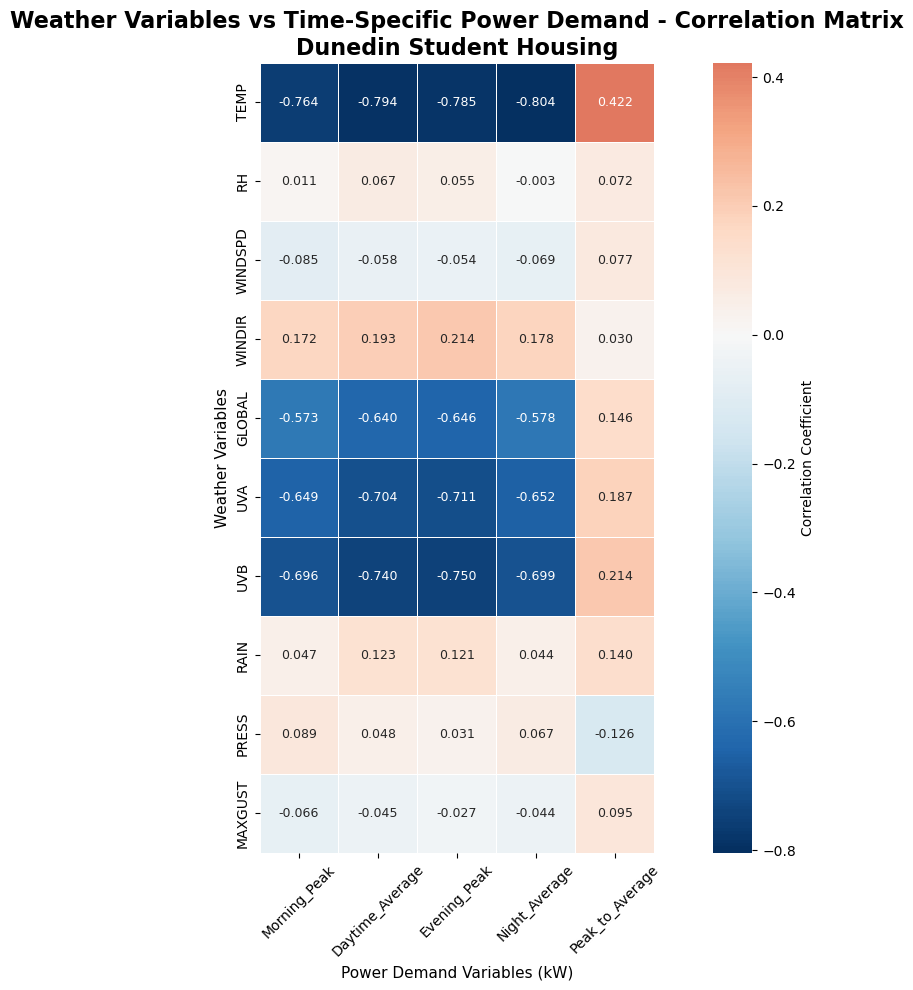

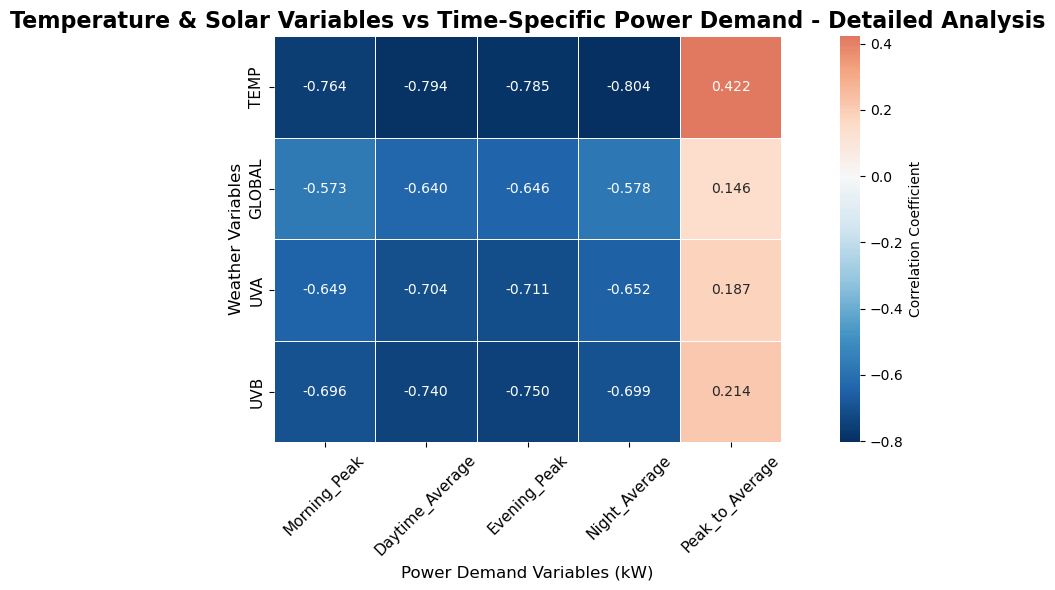

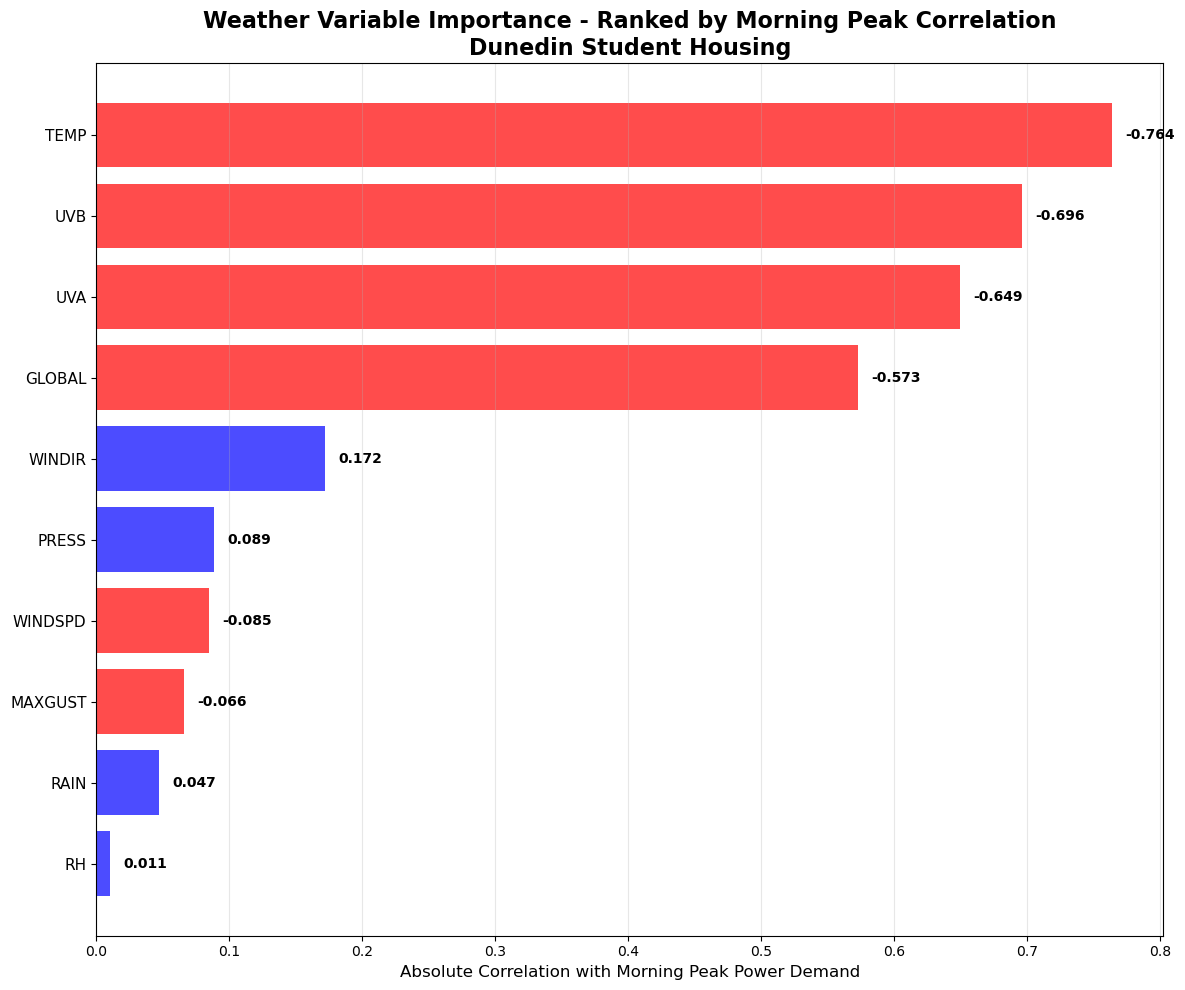

DETAILED CORRELATION RESULTS

Correlations with Morning Peak (06:00-10:00):
  TEMP                :  -0.764 ***
  RH                  :   0.011 
  WINDSPD             :  -0.085 
  WINDIR              :   0.172 *
  GLOBAL              :  -0.573 ***
  UVA                 :  -0.649 ***
  UVB                 :  -0.696 ***
  RAIN                :   0.047 
  PRESS               :   0.089 
  MAXGUST             :  -0.066 

Correlations with Daytime Average (10:00-17:00):
  TEMP                :  -0.794 ***
  RH                  :   0.067 
  WINDSPD             :  -0.058 
  WINDIR              :   0.193 *
  GLOBAL              :  -0.640 ***
  UVA                 :  -0.704 ***
  UVB                 :  -0.740 ***
  RAIN                :   0.123 *
  PRESS               :   0.048 
  MAXGUST             :  -0.045 

Correlations with Evening Peak (17:00-23:00):
  TEMP                :  -0.785 ***
  RH                  :   0.055 
  WINDSPD             :  -0.054 
  WINDIR              :   0.214 **
  G

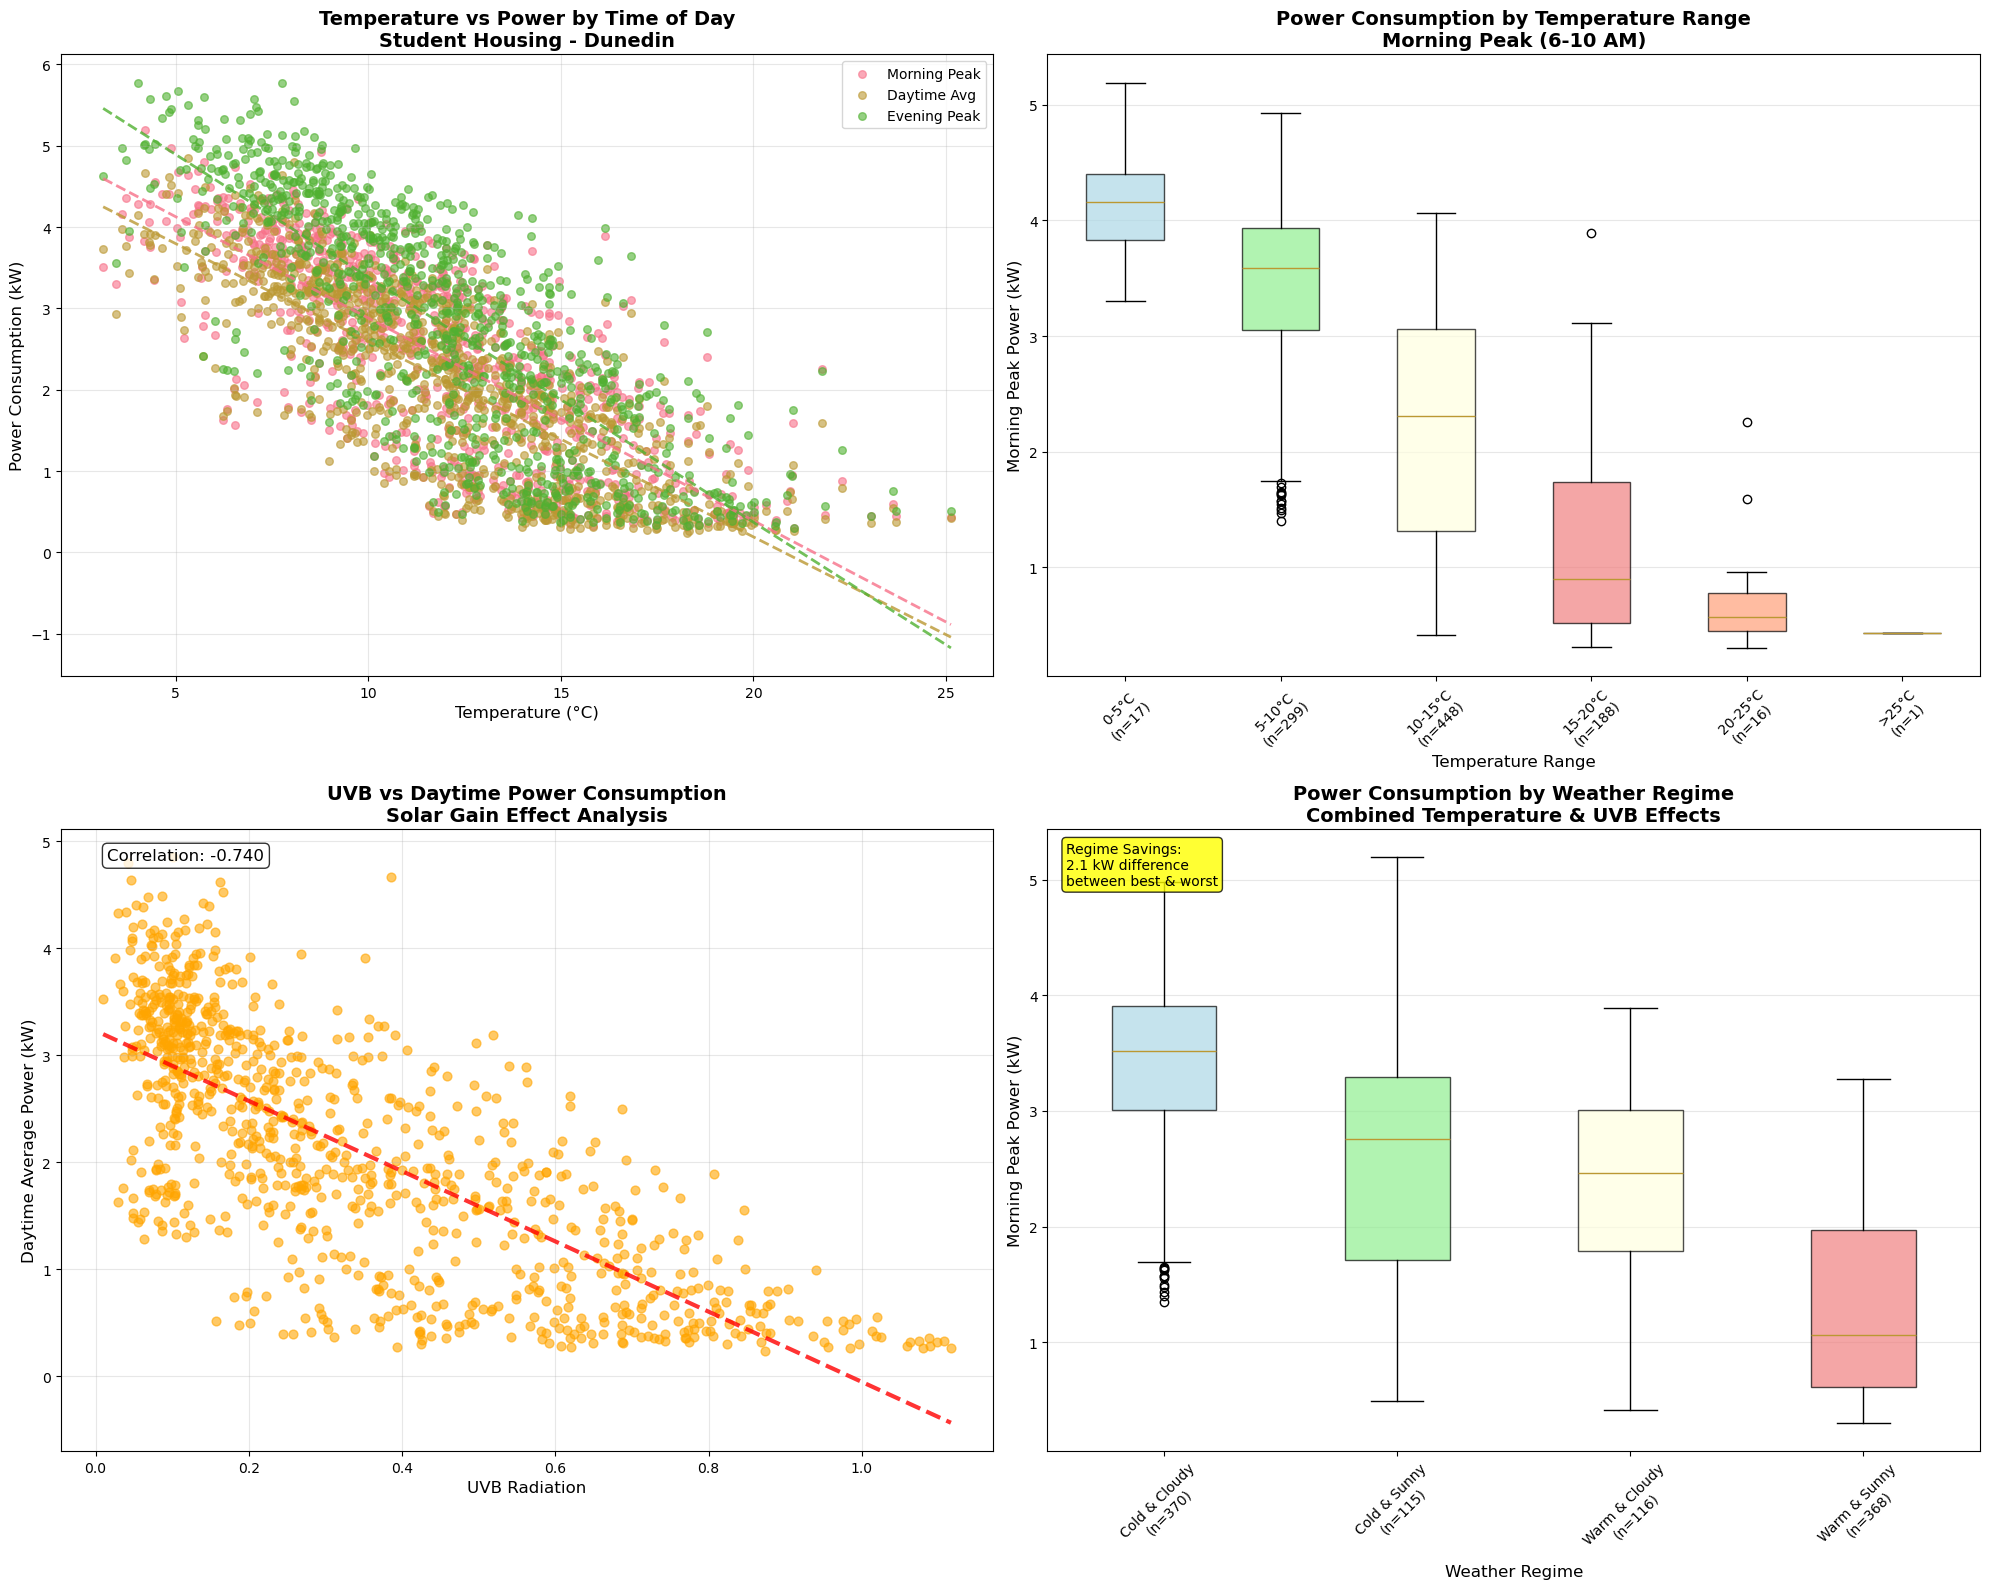

KEY ACTIONABLE INSIGHTS
HEATING THRESHOLD: 13.5°C
Heating increases 1.7 kW when temperature drops below 13.5°C
SOLAR HEATING DISCOUNT: 0.9 kW
Sunny days save 0.9 kW compared to cloudy days at same temperature
HEATING SENSITIVITY: 0.25 kW per °C
   Each 1°C temperature drop increases morning heating by ~0.25 kW
DETAILED WEATHER-POWER ANALYSIS SUMMARY

1. TEMPERATURE ANALYSIS:
   Temperature range: 3.1°C to 25.1°C
   Temperature median: 12.0°C
   Temperature correlations:
     Morning Peak: -0.764
     Daytime Average: -0.794
     Evening Peak: -0.785

2. UVB ANALYSIS:
   UVB range: 0.010 to 1.116
   UVB median: 0.261
   UVB-Daytime Power correlation: -0.740

3. WEATHER REGIME ANALYSIS:
   Average Morning Peak Power by Weather Regime:
     Cold & Cloudy: 3.39 ± 0.75 kW (n=370)
     Cold & Sunny: 2.57 ± 1.02 kW (n=115)
     Warm & Cloudy: 2.37 ± 0.86 kW (n=116)
     Warm & Sunny: 1.32 ± 0.78 kW (n=368)

4. KEY INSIGHTS:
   Most temperature-sensitive period: Daytime Average
   UVB radiatio

In [90]:
df = run_weather_plots()
